#Installations

In [ ]:
!pip install sentence-transformers==1.1.1

     |████████████████████████████████| 81 kB 6.3 MB/s 
     |████████████████████████████████| 2.8 MB 30.0 MB/s 
     |████████████████████████████████| 1.2 MB 33.0 MB/s 
     |████████████████████████████████| 52 kB 1.7 MB/s 
     |████████████████████████████████| 3.3 MB 37.8 MB/s 
     |████████████████████████████████| 895 kB 47.0 MB/s 
     |████████████████████████████████| 636 kB 50.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.1-py3-none-any.whl size=123337 sha256=1bf6a319de0b3183198cb979cf05a2022a12ee7f90ba9c17b7aeca26a32a7092
  Stored in directory: /root/.cache/pip/wheels/9d/f2/81/9a97074f4974b3ade9fee286b3ea9acba88e7c9282928ba187
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install umap-learn

     |████████████████████████████████| 80 kB 6.0 MB/s 
     |████████████████████████████████| 1.1 MB 30.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=a5d8a1cdaa9d04a89541e700945950cd067c85cdb0d1e3e996b53bbb3d93b37f
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=dcdc1f60d553b75e52c54cc11e2f6d2308c026c2106e28901866cbb953edacfc
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent


In [ ]:
pip install hdbscan

     |████████████████████████████████| 6.4 MB 11.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311897 sha256=6292b0f9a3d97f4f3c38740d9f10c44b0e6008064634665fde84c2b68e43962c
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


# Data Pre-processing

## Read All Data

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

In [ ]:
newsgroups = fetch_20newsgroups(remove=('footers', 'quotes'), subset='all')

In [ ]:
df = pd.DataFrame()
df['data'] = newsgroups['data']
df['target'] = newsgroups['target']

In [ ]:
df[df['target']==14].iloc[22].data

"From: ajjb@adam4.bnsc.rl.ac.uk (Andrew Broderick)\nSubject: Re: Solar Sail Data\nKeywords: Solar Sail\nOrganization: Rutherford Appleton Lab, UK\nLines: 79\n\n\nI was at an interesting seminar at work (UK's R.A.L. Space Science\nDept.) on this subject, specifically on a small-scale Solar Sail\nproposed as a student space project. The guy giving the talk was keen to\ngenerate interest in the project. I'll typein the handout he gave out at\nthe meeting. Here goes : \n\n\t\t\tThe Microlight Solar Sail\n\t\t\t-------------------------\n\n1. Introduction\nThe solar sail is a well-established concept. Harnessing the pressure of\nsunlight, a spacecraft would have unlimited range. In principle, such a\nvehicle could explore the whole Solar System with zero fuel consumption.\n\nHowever it is more difficult to design a practical solar sail than most\npeople realize. The pressure of sunlight is only about one kilogram per\nsquare kilometer. Deploying and controlling the large area of aluminized\

## Cleaning

In [ ]:
df['data'] = df['data'].apply(lambda x: x.replace("\n", "").replace("-", "").replace("....", "")) 

In [ ]:
df = df.drop(df[df['data']==''].index)

### Filtering encoded documents

In [ ]:
def chars_for_words(doc, threshold):
    n_words = len(doc.split())
    n_chars = len(doc)
    avg = n_chars/max(n_words,1)
    if (avg > threshold):
        return True
    else:
        False

In [ ]:
def count_charlen(df, threshold):
    count = 0
    index_list = []
    for index, row in df.iterrows():
        if (len(row['data'])>threshold):
            print(len(row['data']))
            count = count + 1
            index_list.append(index)
    return count, index_list

In [ ]:
def filter_encoded(df, threshold):
    index_list = []
    for index, row in df.iterrows():
        if chars_for_words(row['data'], threshold):
            index_list.append(index)
    return index_list

In [ ]:
i = filter_encoded(df,9)

In [ ]:
df = df.drop(i)

In [ ]:
df=df.reset_index().drop('index', axis=1)

# Document Embeddings

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
model = SentenceTransformer('stsb-roberta-base-v2')
embeddings = model.encode(df.data, show_progress_bar=True)

  0%|          | 0.00/460M [00:00<?, ?B/s]

Batches:   0%|          | 0/514 [00:00<?, ?it/s]

In [ ]:
embeddings.shape

(16445, 768)

# Dimensionality Reduction (UMAP)

In [ ]:
import umap

In [ ]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine',
                            random_state=42,
                            n_jobs=2
                            ).fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
umap_embeddings

array([[ 8.369871  , -0.5795741 ,  5.2360854 ,  2.938212  ,  7.8075895 ],
       [ 5.374904  ,  1.1114591 ,  1.0350372 ,  3.0743756 , 11.008506  ],
       [ 8.498473  ,  0.28913718,  5.0724077 ,  3.1225495 ,  6.6268826 ],
       ...,
       [ 8.409246  , -0.15569809,  4.980834  ,  3.1409457 ,  6.691885  ],
       [ 8.618236  , -1.6168393 ,  3.9924798 ,  2.3077219 ,  8.111877  ],
       [ 9.325711  , -0.19935241,  4.314558  ,  1.6990035 ,  8.202628  ]],
      dtype=float32)

# Clustering

## HDBSCAN

In [ ]:
import hdbscan

In [ ]:
hdbscan_clusters = hdbscan.HDBSCAN(min_cluster_size=50,
                          metric='euclidean',
                          #min_samples = 1,                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
hdbscan_clusters

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=50, min_samples=None, p=None,
        prediction_data=False)

In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='cosine', random_state=42).fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = hdbscan_clusters.labels_
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

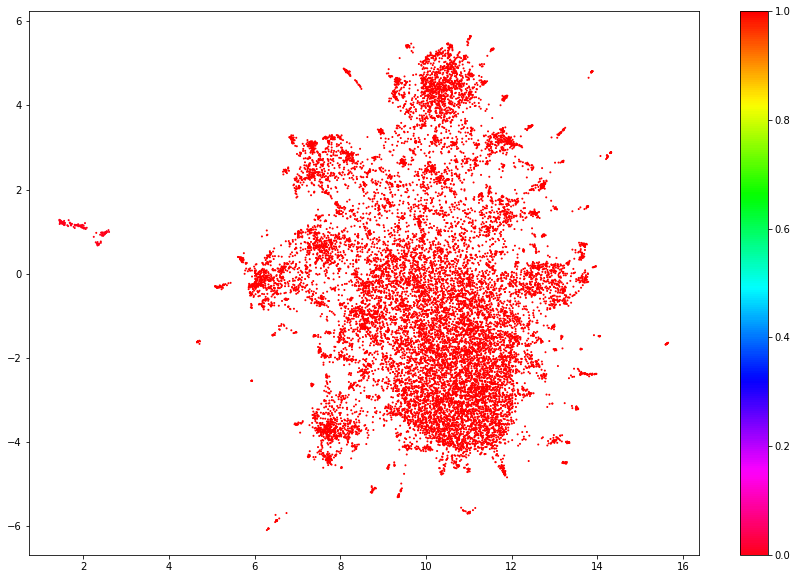

In [ ]:

# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 10))

plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=1)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1, cmap='hsv_r')
plt.colorbar()

In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='cosine', random_state=42).fit_transform(embeddings)

In [ ]:
original = pd.DataFrame(umap_data, columns=['x', 'y'])
original['target'] = df.target.values

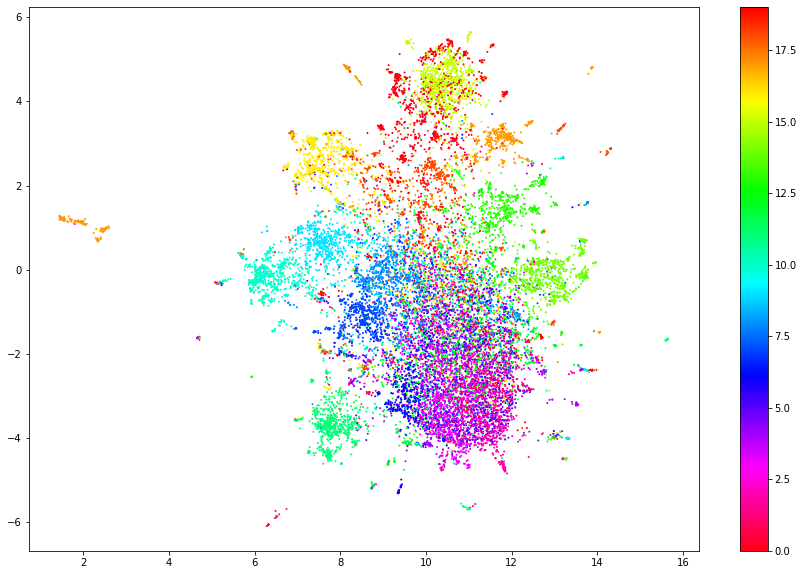

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(original.x, original.y, c=original.target, s=1, cmap='hsv_r')
plt.colorbar()

### 3D

In [ ]:
import plotly.express as px

In [ ]:
# Prepare data
umap_data_3 = umap.UMAP(n_neighbors=15, n_components=3, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

In [ ]:
original = pd.DataFrame(umap_data_3, columns=['x', 'y', 'z'])
original['target'] = df.target.values

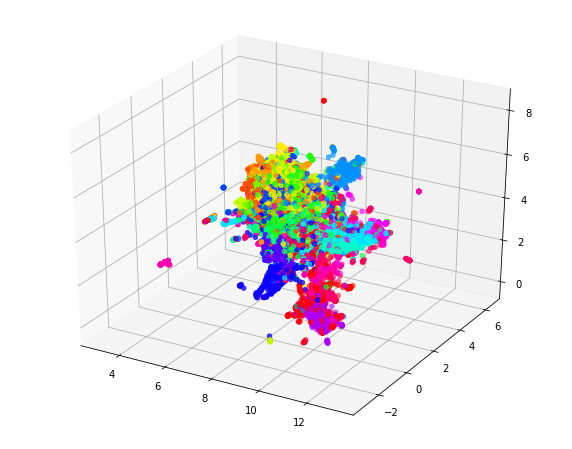

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(original['x'], original['y'], original['z'], c=original.target.values, cmap = 'hsv')
plt.show()

In [ ]:
fig = px.scatter_3d(original, x='x', y='y', z='z',
              color='target', color_continuous_scale='HSV')
fig.show()

# Topics

## TF-IDF

In [ ]:
docs_df = pd.DataFrame(df.data.values, columns=["Doc"])
docs_df['Topic'] = hdbscan_clusters.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [ ]:
docs_per_topic

,Topic,Doc
0,0,From: hilmier@dsv.su.se (Hilmi Eren)Subject: R...
1,1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(df.data.values))

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
1,1,16255
0,0,190


In [ ]:
for i in range(21):
  print(i,top_n_words[i][0:10])

0 [('armenian', 0.025444063424016287), ('armenians', 0.02513760845523472), ('turkish', 0.020560667560985034), ('argic', 0.014112721853751451), ('armenia', 0.01383279129444425), ('serdar', 0.013658725780373637), ('turkey', 0.012917410080953502), ('azerbaijan', 0.012591953433625718), ('said', 0.011310447613464546), ('turks', 0.011237054215477025)]
1 [('com', 0.0032482297070660893), ('organization', 0.003223477564395646), ('like', 0.0031417176877264704), ('use', 0.0031349131104665474), ('just', 0.00313000921095782), ('university', 0.0031296009522986928), ('don', 0.003124629900950359), ('think', 0.003078298166810607), ('know', 0.0030779844320559554), ('does', 0.003023688916847005)]


KeyError: ignored

In [ ]:
def topic_words(topic_number):
    word_list =[]
    for t in top_n_words[topic_number]:
        word_list.append(t[0])
    return word_list

In [ ]:
pd.DataFrame(newsgroups.target_names)

## Mean Vectors

In [ ]:
from functools import reduce
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
df['labels'] = hdbscan_clusters.labels_

In [ ]:
embed_df = pd.DataFrame(columns=['embed'])
embed_df['embed'] = embed_df['embed'].astype(object)

In [ ]:
for i in range(len(embeddings)):
  embed_df.at[i,'embed'] = embeddings[i]

In [ ]:
df['embed'] = embed_df.embed

In [ ]:
clustered = df.loc[df.labels != -1, :]

In [ ]:
clustered = clustered.reset_index()

In [ ]:
cluster_labels_mean = []
for cluster in range(20):
  cluster_mean = clustered[clustered.labels==cluster].embed.values.mean()
  cluster_labels_mean.append(cluster_mean)

In [ ]:
cluster_target_mean = []
for cluster in range(20):
  cluster_mean = clustered[clustered.target==cluster].embed.values.mean()
  cluster_target_mean.append(cluster_mean)

In [ ]:
cos_sim = cosine_similarity(cluster_target_mean,cluster_labels_mean)

In [ ]:
fig = plt.figure(figsize=(15,9))
ax = sns.heatmap(cos_sim, annot=True)